In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

### imports and utilities

In [253]:
from utils import *
from word_network import WordNetwork

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from sklearn.preprocessing import normalize
from sklearn.datasets import fetch_20newsgroups
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from scipy.stats import entropy as calculate_entropy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [254]:
# fetch data
docs = load_data(1000)
print(f"there are {len(docs)} docs")

there are 1000 docs


In [267]:
# initialize network
word_network = WordNetwork()

# train the network
print("\nTraining\n" + "="*30)
word_network.train(docs)
print(f"discovered {len(word_network.word_nodes)} words!\n")  

  0%|                                                                                                                                         | 0/2148 [00:00<?, ?it/s]


Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2148/2148 [00:59<00:00, 36.14it/s]

discovered 58959 words!



In [273]:
# show topwords related to computer
show_topwords(word_network, "computer", ["computing"])

word_node is [COMPUTER]
computing        0.4988



### load dataset

In [257]:
# total number of samples needed
datasize = 300
randomize = False

# retrieve dataset
categories = ['rec.autos', 'talk.religion.misc', 'comp.graphics', 'sci.space']
label_classes = ['autos', 'religion', 'graphics', 'space']

assert len(label_classes) == len(categories)

docs = fetch_20newsgroups(subset='train', shuffle=randomize, remove=('headers', 'footers', 'quotes'), categories=categories)
docs, old_labels, classes = docs.data, docs.target, docs.target_names

### clean dataset

In [258]:
labels = []
clean_docs = []
max_document_length = None

# the new classes
sizes = [0] * len(label_classes)
assert len(label_classes) == len(sizes)

for index, doc in enumerate(docs):
    if len(clean_docs) == datasize*len(label_classes):
        break
        
    cd = clean_doc(doc)
    
    if len(cd) == 0 or cd.isspace() or (max_document_length is not None and len(cd) <= max_document_length):
        continue
        
    label_class = classes[old_labels[index]]
    label = categories.index(label_class)

    if sizes[label] < datasize:
        clean_docs.append(cd)
        labels.append(label)

        sizes[label] += 1

labels = np.array(labels)
print(clean_docs[0])

apparently you re not a woman   my husband hates the auto door locks
 feels safer in a car that locks easily  in addition to watching around
 in a secluded spot  etc   have my keys ready to open the door so i m


In [259]:
print(f"there are {len(clean_docs)} docs and {len(label_classes)} classes: {label_classes} of size min:{min(sizes)}, max:{max(sizes)}")

there are 1200 docs and 4 classes: ['autos', 'religion', 'graphics', 'space'] of size min:300, max:300


### count words

In [260]:
# initialize the count vectorizer
count_vectorizer = CountVectorizer()
# count_vectorizer = TfidfVectorizer()

# fit it to dataset
train_docs, test_docs, train_labels, test_labels = train_test_split(clean_docs, labels, test_size=.33, random_state=42)

count_vectorizer.fit(train_docs)
vocabulary = count_vectorizer.get_feature_names()

print("word_count is", len(vocabulary))

word_count is 17742


### Prepare Datatset

In [261]:
# create doc count vectors
train_doc_vectors = count_vectorizer.transform(train_docs).toarray()
train_doc_vectors = (train_doc_vectors > 0).astype(float)
train_doc_vectors = normalize(train_doc_vectors, norm="l1", axis=1)

test_doc_vectors = count_vectorizer.transform(test_docs).toarray()
test_doc_vectors = (test_doc_vectors > 0).astype(float)
test_doc_vectors = normalize(test_doc_vectors, norm="l1", axis=1)

print(f"{len(train_labels)} train_docs, {len(test_labels)} test docs")

804 train_docs, 396 test docs


In [262]:
document_word_frequency = pd.DataFrame(train_doc_vectors, columns=count_vectorizer.get_feature_names())
document_word_frequency["__labels__"] = train_labels

print("document_word_frequency shape is", document_word_frequency.shape)

document_word_frequency shape is (804, 17743)


In [263]:
print(f"there are {len(clean_docs)} docs and {len(label_classes)} classes")

there are 1200 docs and 4 classes


In [264]:
document_word_frequency.head()

,00,000,0000,00000,0001,000100255pixel,00041032,0004136,0004246,0004422,...,zullen,zulu,zurbrin,zurvanism,zwaartepunten,zwak,zwakke,zware,zwarte,__labels__
0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.000388,0.000388,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
4,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


### Prepare Binary Dataset

In [265]:
#reduce freq in doc to bin value of 1 or 0
word_doc_freqency = document_word_frequency.drop(["__labels__"], axis='columns')

#the sum vertically of bin freq
word_doc_total_frequency = word_doc_freqency.sum(0)

### Word-Word Ratio

In [293]:
word_word_co = pd.DataFrame(data=0.0, columns=vocabulary, index=vocabulary)

for i in tqdm(range(len(vocabulary))):
    w1 = vocabulary[i]
    
    for j, w2 in enumerate(vocabulary[:10]):
        word_word_co[w1][w2] = word_network.get_co_occurence(w1, [w2]).get(w2, 0)
          
print(f"word_word_co has shape {word_word_co.shape}")

KeyboardInterrupt: 

In [ ]:
word_word_co.head()

### Topic and word corelation

In [286]:
topic_word_distr.loc[["computer", "adebola"]]

KeyError: 'Passing list-likes to .loc or [] with any missing labels is no longer supported, see https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike'

In [236]:
topic_word_distr = pd.DataFrame(data=0.0, columns=label_classes, index=vocabulary)

for topic, label in enumerate(label_classes):
    word_topic_frequency = word_doc_freqency[document_word_frequency['__labels__'] == topic].sum(0)
#     trust_factor = (word_doc_freqency > 0).sum(0)
#     trust_factor = trust_factor / (trust_factor + 1)
    trust_factor = sigmoid((word_doc_freqency > 0).sum(0))
    
    topic_word_distr[label] = ((word_topic_frequency * trust_factor) / word_doc_total_frequency).fillna(0)

# entropy = topic_word_distr.std(1)
entropy = sigmoid(np.nan_to_num(calculate_entropy(topic_word_distr.T, base=2)))
skew_factor = gaussian(entropy)

topic_word_distr = (topic_word_distr.T * skew_factor).T
print(f"topic_word_distr has shape {topic_word_distr.shape}")

topic_word_distr has shape (17523, 4)


In [237]:
topic_word_distr.head()

,autos,religion,graphics,space
00,0.036319,0.009206,0.376589,0.128523
000,0.341298,0.038339,0.086055,0.053895
0000,0.000000,0.000000,0.000000,0.685965
00000,0.000000,0.000000,0.000000,0.685965
0001,0.000000,0.569349,0.000000,0.000000


In [238]:
label_classes

['autos', 'religion', 'graphics', 'space']

In [239]:
label_class = 'graphics'
topic_word_distr[label_class][topic_word_distr[label_class] > 0].sort_values(ascending=False)

3d             0.778801
vga            0.778800
animation      0.778799
formats        0.778796
programming    0.778796
                 ...   
moon           0.000765
government     0.000758
days           0.000739
man            0.000627
cars           0.000500
Name: graphics, Length: 6721, dtype: float64

In [240]:
word="the"
topic_word_distr.loc[word].sort_values(ascending=False)

autos       0.127230
graphics    0.116414
religion    0.114527
space       0.102520
Name: the, dtype: float64

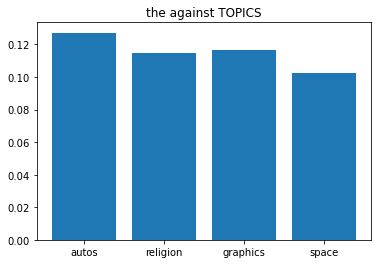

In [241]:
plt.title(f"{word} against TOPICS")
plt.bar(topic_word_distr.loc[word].index, topic_word_distr.loc[word])
plt.show()

### Evaluate Topic model with Train set

In [242]:
score = 0
misclassified_train = []
print("Evaluating Topic Model...")

for doc_index in tqdm(range(len(train_labels))):
    doc_vector = train_doc_vectors[doc_index]
    
    doc_topic_word_distr, doc_topic = infer_topic(label_classes, doc_vector, topic_word_distr)
    score += int(doc_topic == label_classes[train_labels[doc_index]])
    
    if doc_topic != label_classes[train_labels[doc_index]]:
        misclassified_train.append(doc_index)
    
train_accuracy = score / (doc_index + 1)
print(f"==> train-accuracy is {train_accuracy*100:.2f}%, {len(misclassified_train)} misclassified\n")

Evaluating Topic Model...



==> train-accuracy is 99.75%, 2 misclassified



### Evaluating Topic Model with test set

In [243]:
score = 0
print("Evaluating Topic Model...")

misclassified_test = []
for doc_index in tqdm(range(len(test_labels))):
    doc_vector = test_doc_vectors[doc_index]
    
    doc_topic_word_distr, doc_topic = infer_topic(label_classes, doc_vector, topic_word_distr)
    score += int(doc_topic == label_classes[test_labels[doc_index]])
    
    if doc_topic != label_classes[test_labels[doc_index]]:
        misclassified_test.append(doc_index)
    

test_accuracy = score / (doc_index + 1)
print(f"==> test-accuracy is {test_accuracy*100:.2f}%, avg-accuarcy = {.5*(train_accuracy + test_accuracy)*100:.2f}%, {len(misclassified_test)} misclassified\n")

Evaluating Topic Model...



==> test-accuracy is 83.59%, avg-accuarcy = 91.67%, 65 misclassified



### Investigating Misclassification

In [88]:
training = False
tlabels = train_labels if training else test_labels
tdoc_vectors = train_doc_vectors if training else test_doc_vectors
misclassified = misclassified_train if training else misclassified_test

for doc_index in tqdm(misclassified):
    doc_vector = tdoc_vectors[doc_index]
    doc_topic_word_distr, doc_topic = infer_topic(label_classes, doc_vector, topic_word_distr)
    
    xv = doc_topic_word_distr.iloc[np.where(doc_topic_word_distr.sum(1) > 0)]
    print(xv.loc[xv.sum(1).sort_values(ascending=False).index])
    print(train_docs[doc_index])
    print(f"predicted_topic = {doc_topic}, actual_topic = {label_classes[tlabels[doc_index]]} \n")

              autos  religion  graphics     space
88         0.000000  0.000000  0.040036  0.000000
december   0.008082  0.000749  0.012092  0.000327
built      0.003646  0.000754  0.001778  0.010949
difficult  0.002238  0.003982  0.005447  0.000406
away       0.004236  0.002955  0.000506  0.002587
pretty     0.003046  0.002584  0.001332  0.001207
early      0.002406  0.002300  0.000946  0.002012
so         0.002449  0.002053  0.001952  0.001025
certainly  0.001410  0.002650  0.001444  0.001820
most       0.001550  0.001717  0.001383  0.002623
which      0.001412  0.002400  0.001979  0.001381
you        0.002028  0.001589  0.001969  0.001328
was        0.002192  0.001619  0.001444  0.001635
have       0.002154  0.001567  0.001716  0.001438
and        0.001799  0.001543  0.002066  0.001433
it         0.001969  0.001366  0.001838  0.001647
as         0.001688  0.001965  0.001366  0.001790
do         0.001475  0.001952  0.001862  0.001506
be         0.001561  0.001844  0.001500  0.001824


             autos  religion  graphics     space
lovely    0.000000  0.000000  0.036700  0.000000
dwell     0.000000  0.030461  0.000000  0.000000
worthy    0.000000  0.023847  0.000000  0.005375
praise    0.014507  0.010484  0.000000  0.000000
phil      0.000000  0.010980  0.000000  0.011737
pure      0.000000  0.005836  0.003049  0.004284
whatever  0.001580  0.005382  0.003339  0.000638
true      0.002072  0.004942  0.001582  0.001041
right     0.004786  0.001276  0.001267  0.002100
any       0.002124  0.001441  0.003751  0.001022
things    0.001409  0.002351  0.000953  0.003215
let       0.002983  0.001948  0.001535  0.000998
mind      0.001341  0.003050  0.001327  0.001613
finally   0.001067  0.002056  0.002559  0.001386
your      0.002740  0.001751  0.001356  0.001211
good      0.002341  0.001969  0.001872  0.000872
anything  0.001285  0.001800  0.001255  0.002460
on        0.001754  0.001133  0.002222  0.001493
these     0.002198  0.001746  0.001519  0.001123
there     0.001563  

              autos  religion  graphics     space
lord       0.000000  0.012799  0.000000  0.000245
equations  0.000000  0.000000  0.012280  0.000469
solve      0.000000  0.000000  0.012534  0.000000
iti        0.000000  0.000000  0.000542  0.011581
rid        0.011094  0.000980  0.000000  0.000000
...             ...       ...       ...       ...
the        0.000536  0.000483  0.000491  0.000432
to         0.000516  0.000463  0.000525  0.000437
is         0.000442  0.000543  0.000487  0.000468
in         0.000545  0.000475  0.000462  0.000457
of         0.000497  0.000509  0.000475  0.000450

[76 rows x 4 columns]
hi there ...   well, i have a 386/40 with svga 1mb.  oak chip 077  and i don t   have vesa tsr program for this card. i need it .     please... if anybody can help me, mail me at:    lulagos@araucaria.cec.uchile.cl
predicted_topic = religion, actual_topic = graphics 

                autos  religion  graphics     space
chip         0.022955  0.000000  0.020523  0.000000
phon

i m using  rayshade  on the u.w. computers here, and i d like input from other users, and perhaps swap some ideas.  i could post uuencoded .gifs here, or .ray code, if anyone s interested.  i m having trouble coming up with colors that are metallic  i.e. brass, steel  from the rgb values.  if you re on the u.w. machines, check out  ~fineman/rle.files/*.rle  on  stein.u.washington.edu for some of what i ve got.
predicted_topic = religion, actual_topic = space 

            autos  religion  graphics     space
lisa     0.000000  0.121843  0.000000  0.000000
preston  0.000000  0.000000  0.000000  0.121843
reply    0.008873  0.014253  0.019370  0.001332
edu      0.010487  0.002057  0.017159  0.008925
to       0.006541  0.005868  0.006647  0.005530
in       0.006900  0.006021  0.005852  0.005792
what is the phone number for alias? a toll-free number is preferred, if available.  thanks
predicted_topic = religion, actual_topic = graphics 

               autos  religion  graphics     space
ut 

In [89]:
xv = train_doc_vectors[:, vocabulary.index("enough")]
xv[xv.argsort()[::-1]][:20]

array([0.07692308, 0.03846154, 0.03703704, 0.03225806, 0.02777778,
       0.02631579, 0.02564103, 0.025     , 0.02380952, 0.02325581,
       0.02      , 0.01960784, 0.01923077, 0.01818182, 0.01785714,
       0.01694915, 0.01587302, 0.01408451, 0.01351351, 0.01123596])

In [90]:
for index in xv.argsort()[::-1][:20]:
    print(train_docs[index], '====>', label_classes[train_labels[index]])
    print()

usually....go enough places and you ll see stuff happen you didn t think did. ====> autos

where does the shadow come from?  there s nothing close enough to block sunlight from hitting them.  i wouldn t expect there to be anything block our view of them either.  what am i missing? ====> space

if raw materials where to cost enough that getting them from space would be cost effective then the entire world economy would colapse long before the space mines could be built.    allen ====> space

too many clues, not enough substance.  you ask a lot of good questions, though, but they are questions *you* should be worried about, not me.  i m not the inerrantist here.  let me know when you are ready to get serious. ====> religion

recently-manufactured locomotives have wheel-slip detection systems that use frequencies shared with police radar  i forget which band . these will set off your radar detector if you get close enough, though i believe the range is pretty short. ====> autos

right. in

In [116]:
xv.argsort()[::-1][20]

342